# drafts on root-finding methods to invert pricing formula

- This library aanswers: given vol( sigma ) what is the price? .. But market asks : given the priice what sigma are the. marklets implying, “What happens when closed-form doesn’t exist?”

- Sigma is the encoding of **market belief** about future certainty 


## notes:
- BS price is monotonically increasing in sigma -> existence of implied volatility? uniqueness?  (to demonstrate)

In [2]:
import numpy as np 
from core import BlackScholesModel,  EuropeanCall
from greeks import CallGreeks

In [3]:
# first simple implementation (dichotomic )

def find_IV_dichotomic( option , market_price , iv_low,iv_high, tolerance=1e-6):
    # monotonicity precondition check

    r = 0.05
    f_low = option.price(BlackScholesModel(r=r, sigma=iv_low)) - market_price
    f_high = option.price(BlackScholesModel(r=r, sigma=iv_high)) - market_price

    assert f_low * f_high < 0,  "Root not bracketed"
    iv_mid = None

    while iv_high - iv_low >tolerance:

        iv_mid = (iv_high + iv_low)/2

        model = BlackScholesModel(r = r, sigma=iv_mid)
        BS_price = option.price(model)
        f = BS_price - market_price

        if f == 0:
            break
        if f < 0:
            iv_low = iv_mid
        else :
            iv_high = iv_mid

    return iv_mid

    



In [4]:
S = 100
K = 100
T = 1.0
r = 0.05
true_sigma = 0.20  
option = EuropeanCall(S=S, K=K, T=T)
model = BlackScholesModel(r=r, sigma=true_sigma)

market_price = option.price(model)


iv_low = 0.01
iv_high = 1.00

iv_estimated = find_IV_dichotomic(
    option = option, 
    market_price=market_price,
    iv_low=iv_low,
    iv_high=iv_high,
    tolerance=1e-6
)
iv_estimated

0.19999918937683103

In [ ]:
def find_IV_newton_raphson(option, market_price, init_guess,
                           max_iter=100, vol_tol=1e-6, price_tol=1e-8):

    iv = init_guess
    r = 0.05

    for _ in range(max_iter):
        model = BlackScholesModel(r=r, sigma=iv)
        price = option.price(model)
        diff = price - market_price

        if abs(diff) < price_tol:
            return iv

        vega = CallGreeks(option, model).vega() # could add a sanity check for low vega 
        if vega < vol_tol:
            break 

        iv_new = iv - diff / vega

        
        iv = iv_new

    return iv


In [6]:
find_IV_newton_raphson(option=option, market_price=market_price, init_guess= 0.1)

np.float64(0.20000000000304766)

In [7]:
from scipy import optimize

def f(x):
    return (x**2 - 1)
root = optimize.brentq(f, -2, 0)
root

-1.0

In [8]:
help(optimize.brentq)

Help on function brentq in module scipy.optimize._zeros_py:

brentq(
    f,
    a,
    b,
    args=(),
    xtol=2e-12,
    rtol=np.float64(8.881784197001252e-16),
    maxiter=100,
    full_output=False,
    disp=True
)
    Find a root of a function in a bracketing interval using Brent's method.

    Uses the classic Brent's method to find a root of the function `f` on
    the sign changing interval [a , b]. Generally considered the best of the
    rootfinding routines here. It is a safe version of the secant method that
    uses inverse quadratic extrapolation. Brent's method combines root
    bracketing, interval bisection, and inverse quadratic interpolation. It is
    sometimes known as the van Wijngaarden-Dekker-Brent method. Brent (1973)
    claims convergence is guaranteed for functions computable within [a,b].

    [Brent1973]_ provides the classic description of the algorithm. Another
    description can be found in a recent edition of Numerical Recipes, including
    [PressEta

# BRENT = Speed when possible Safety when necessary
- **Secant method** : take two points from f -> make a line -> the intersection with X-axis is the next guess 
- **Inverse quandratic interpolation** :take three points -> σ = g(f) -> fit a quadratic curve through the 3 pts -> eval at f=0-> result is next σ


In [9]:
def find_IV_brent(
    option,
    market_price,
    iv_low,
    iv_high,
    r=0.05,
    vol_tol=1e-6,
    price_tol=1e-8,
    max_iter=100
):
    def f(iv):
        return option.price(BlackScholesModel(r=r, sigma=iv)) - market_price

    a, b = iv_low, iv_high
    fa, fb = f(a), f(b)

    assert fa * fb < 0, "Root not bracketed"

    c, fc = a, fa
    d = e = b - a

    for _ in range(max_iter):

        if abs(fc) < abs(fb):
            a, b, c = b, c, b
            fa, fb, fc = fb, fc, fb

        tol = 2 * np.finfo(float).eps * abs(b) + vol_tol
        m = 0.5 * (c - b)

        # ---- stopping condition ----
        if abs(m) <= tol or abs(fb) < price_tol:
            return b

        # ---- try interpolation ----
        if abs(e) >= tol and abs(fa) > abs(fb):

            s = fb / fa

            if a == c:
                # secant
                p = 2 * m * s
                q = 1 - s
            else:
                # inverse quadratic interpolation
                q = fa / fc
                r_ = fb / fc
                p = s * (2 * m * q * (q - r_) - (b - a) * (r_ - 1))
                q = (q - 1) * (r_ - 1) * (s - 1)

            if p > 0:
                q = -q
            p = abs(p)

            if (2 * p < min(3 * m * q - abs(tol * q), abs(e * q))):
                e = d
                d = p / q
            else:
                d = m
                e = m
        else:
            d = m
            e = m

        a, fa = b, fb
        b = b + d if abs(d) > tol else b + np.sign(m) * tol
        fb = f(b)

        if (fb > 0 and fc > 0) or (fb < 0 and fc < 0):
            c, fc = a, fa
            e = d = b - a

    return b


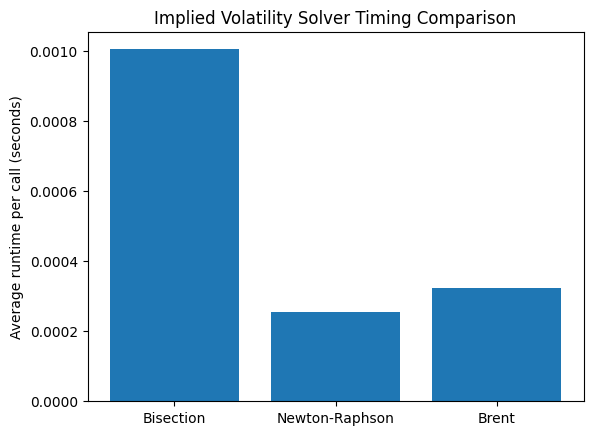

{'Bisection': 0.0010058767079899552,
 'Newton-Raphson': 0.00025449387499247675,
 'Brent': 0.0003242080000054557}

In [11]:
import time
import matplotlib.pyplot as plt
from core import BlackScholesModel,EuropeanCall

# --- test case ---
S, K, T, r = 100, 100, 1.0, 0.05
true_sigma = 0.20

option = EuropeanCall(S=S, K=K, T=T)
market_price = option.price(BlackScholesModel(r=r, sigma=true_sigma))

# --- timing helper ---
def time_method(func, n_runs=1000):
    start = time.perf_counter()
    for _ in range(n_runs):
        func()
    return (time.perf_counter() - start) / n_runs

# --- timing each solver ---
times = {
    "Bisection": time_method(
        lambda: find_IV_dichotomic(
            option, market_price, iv_low=0.01, iv_high=1.0
        )
    ),
    "Newton-Raphson": time_method(
        lambda: find_IV_newton_raphson(
            option, market_price, init_guess=0.30
        )
    ),
    "Brent": time_method(
        lambda: find_IV_brent(
            option, market_price, iv_low=0.01, iv_high=1.0
        )
    )
}

# --- plot ---
plt.figure()
plt.bar(times.keys(), times.values())
plt.ylabel("Average runtime per call (seconds)")
plt.title("Implied Volatility Solver Timing Comparison")
plt.show()

# optional: inspect raw numbers
times


- newtong-raphson is best performing .. but not safe /garanteed because vega can be arbitrarily very small . and Newton does not preserve braketing
- if initial guess is poor or price curve is flat . the method occilates/cycle 
